# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

In [1]:
# Based on job information, we must predict salaries.  

Write the problem in your own words here

In [1]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle

#your info here
__author__ = "Khalid Rahman"
__email__ = "kirahman2@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [3]:
# 1. COMPLETED create model container, 
# 2. test new features
# 3. tuning model 
# 4. Intend on creating new features and seeing how you can improve the model.
# Later: -store model in file -load model

### ---- 3 Clean the data ----

### ---- 4 Explore the data (EDA) ----

In [621]:
class Data:
    def __init__(self, train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target):
        self.col_cat = col_cat
        self.col_num = col_num
        self.col_all = col_cat + col_num
        self.col_id = col_id
        self.col_target = col_target
        self.train_df_eda = self._create_train_eda(train_file, train_target_file)
        self.train_df = self._create_train_df(train_file, train_target_file)
#         self.train_df = self._shuffle_data(self.train_df) # KEEP
        self.test_df = self._create_test_df(test_file)
        
    def _create_train_df(self, train_feature_df, train_target_df):
        train_target = self._load_file(train_target_df)
        train_df = self._load_file(train_feature_df)
        train_df = self._join_df(train_df, train_target, col_id)
        train_df = self._clean_data(train_df)
        train_df = self._label_encode(train_df, self.col_cat)
        return train_df
    
    def _create_train_eda(self, train_feature_df, train_target_df):
        train_target = self._load_file(train_target_df)
        train_df = self._load_file(train_feature_df)
        train_df = self._join_df(train_df, train_target, col_id)
        train_df = self._clean_data(train_df)
        return train_df
    
    def _create_test_df(self, test_file):
        test_df = self._load_file(test_file)
        test_df = self._label_encode(test_df, col_cat)
        return test_df

    def _shuffle_data(self, train_df):
        train_df = shuffle(train_df, random_state=42)
        return train_df

    def _clean_data(self, df):
        train_df = df
        train_df = train_df[train_df.salary>0]
        return train_df
    
    def _label_encode(self, train_df, col_cat):
        le = LabelEncoder()
        for col in col_cat:
            train_df[col] = le.fit_transform(train_df[col])
        return train_df
         
    def _join_df(self, train_df, train_target, col_id):
        return pd.merge(train_df, train_target, on=col_id, how='inner')

    def _load_file(self, file):
        return pd.read_csv(file)
    
train_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_features.csv'
test_file = '/Users/krahman/work/salarypredictionportfolio_old/data/test_features.csv'
train_target_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_salaries.csv'
col_cat = ['companyId', 'jobType', 'degree', 'major', 'industry']
col_num = ['milesFromMetropolis', 'yearsExperience']
col_all = col_cat + col_num
col_id = 'jobId'
col_target = 'salary'

data = Data(train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target)

In [622]:
class FeatureEngineering:
    def __init__(self, data):
        self.data = data
        self.group_df = data.train_df.groupby(col_cat)
        self.group_df = self._calculate_stats(self.group_df)
        self._add_columns(self.group_df)
#         self.group_df = self._merge_df(data.train_df, self.group_df)
        self.data.train_df = self._merge_df(data.train_df, self.group_df)
        self.data.test_df = self._merge_df(data.test_df, self.group_df)
        
    def _calculate_stats(self, group_df):
        group_df = pd.DataFrame({'group_mean': group_df[data.col_target].mean()})
        group_df['group_min'] = self.group_df[data.col_target].min()
        group_df['group_max'] = self.group_df[data.col_target].max()
        group_df['group_std'] = self.group_df[data.col_target].std()
        group_df['group_median'] = self.group_df[data.col_target].median()
        return group_df
    
    def _merge_df(self, feature_df, group_df):
        final_df = pd.merge(left=feature_df, right=group_df, how='left', on=col_cat)
        final_df = final_df.fillna(0)
        return final_df
    
    def _add_columns(self, group_df):
        col_add = list(group_df.columns)
        col_temp = data.col_all + col_add
        self.data.col_all = data.col_all + col_add
        return

fe = FeatureEngineering(data)

In [485]:
class Model:
    def __init__(self, train_features, train_target, model_container, set_cv, num_proc, dir_pred):
        self.train_features = train_features
        self.train_target = train_target
    
    def add_model(self, model):
        model_container[model] = self._score_model(model, self.train_features, self.train_target, set_cv, num_proc)
    
    def fit_model(self, model, train_df, train_target):
        return model.fit(train_df, train_target)
        
    def predict_model(self, model_selected, test_df, train_df, train_target):
        model = self.fit_model(model_selected, train_df, train_target)
        prediction_results = model.predict(test_df)
        self._save_prediction(prediction_results)
        return prediction_results
        
    def best_scoring_model(self, model_container):
        best_model = min(model_container, key=model_container.get)
        best_score = model_container.get(best_model)
        self._print_summary(best_model, best_score)
        return best_model
    
    def _print_summary(self, best_model, best_score):
        print('The best model is:\n', best_model)
        print('\nThe best score is:', best_score)
        
    def _score_model(self, model, train_df, target_train, set_cv, num_proc):
        return -1.0*np.mean(cross_val_score(model, train_df, target_train, scoring='neg_mean_squared_error', cv=set_cv, n_jobs=num_proc))

    def _save_prediction(self, prediction_results):
        prediction_results = pd.DataFrame(prediction_results).to_csv(dir_pred)


In [623]:
df1 = data.train_df_eda
df2 = df1[['jobType','salary']].groupby('jobType').mean().sort_values('salary',ascending=True).reset_index()
jobtypes_list = df2.jobType.unique()

dict_jobtypes = {}
avg_salary_list = []
for val in range(0,len(df2)):
    val2 = df2.loc[val,'salary'] / df2.loc[len(df2)-1,'salary']
    avg_salary_list.append(val2)

for i in range(0,len(jobtypes_list)):
    dict_jobtypes.update([(jobtypes_list[i], avg_salary_list[i])])

df1['jobType_ratio'] = df1.jobType.map(dict_jobtypes)

In [624]:
df1['jobType_ratio'].shape

(999995,)

In [625]:
train_features = data.train_df[data.col_all]
train_features.shape

(999995, 12)

In [626]:
train_features = pd.concat([train_features, df1['jobType_ratio']],axis=1)
train_features.shape
# NEXT, figure out why when we concat, we have 1,000,000 rows and NaNs...then clean up code, 

(1000000, 13)

In [629]:
train_features = train_features.loc[:999994,:]

,companyId,jobType,degree,major,industry,milesFromMetropolis,yearsExperience,group_mean,group_min,group_max,group_std,group_median,jobType_ratio
0,31.0,1.0,3.0,6.0,3.0,83.0,10.0,130.875000,98.0,150.0,19.555324,136.0,0.932195
1,11.0,0.0,2.0,7.0,6.0,73.0,3.0,138.031250,90.0,204.0,29.306248,132.0,1.000000
2,48.0,7.0,1.0,8.0,3.0,38.0,10.0,142.000000,116.0,173.0,28.827071,137.0,0.862758
3,32.0,5.0,1.0,2.0,0.0,17.0,8.0,129.000000,77.0,169.0,29.251781,131.0,0.793940
4,60.0,7.0,0.0,8.0,2.0,16.0,8.0,153.583333,94.0,232.0,46.310137,141.5,0.862758
5,7.0,5.0,1.0,3.0,2.0,31.0,2.0,153.750000,113.0,206.0,39.769125,148.0,0.793940
6,7.0,1.0,4.0,7.0,3.0,24.0,23.0,119.134615,65.0,178.0,28.136940,120.5,0.932195
7,17.0,4.0,0.0,2.0,1.0,70.0,9.0,68.818182,46.0,90.0,13.622174,72.0,0.656061
8,13.0,3.0,2.0,7.0,1.0,54.0,1.0,50.727273,19.0,97.0,18.189992,50.0,0.487319
9,36.0,7.0,0.0,2.0,0.0,68.0,17.0,124.625000,71.0,186.0,35.904387,117.0,0.862758


In [633]:
# train_features = data.train_df[data.col_all]
# train_features = pd.concat([train_features,df1['jobType_ratio']],axis=1)

train_target = data.train_df[col_target]
test_df = data.test_df[data.col_all]

# data = Data(train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target)      
# fe = FeatureEngineering(data)
# Heatmap(train_features, train_target, 'Heatmap of Correlation Matrix');

set_cv = 2
num_proc = -1
dir_pred = '/Users/krahman/work/salarypredictionportfolio_old/data/prediction/prediction_results.csv'
model_container = {}
model = Model(train_features, train_target, model_container, set_cv, num_proc, dir_pred)
# 314.8

In [634]:
model.add_model(GradientBoostingRegressor(loss='ls', learning_rate=.1, alpha=.1, n_estimators=180, subsample=1, max_depth=4))
# model.add_model(LinearRegression())
selected_model = model.best_scoring_model(model_container)
# model.predict_model(selected_model, test_df, train_features, train_target)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [568]:
# # we need to ingest a model, ingest parameters, create param_grid
# class RandomSearch:
#     def __init__(self, model):
#         self.model = model
#     return
# gs = RandomSearch()

In [147]:
# # TESTING BY INDUSTRY 
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import RandomizedSearchCV
# import time

# # before we score it, we need to predict, then inverse transform
# def scoring_gbr_gs():
#     score_total = 0
#     loss_types = ['ls', 'lad', 'huber', 'quantile']
#     learning_rate = [.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9]
#     alpha= [.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95]
#     n_estimators = [100,200,300,400,600,1000,2000]
#     subsample =[1,.9,.8,.7,.6,.5,.4,.3,.2,.1]
#     max_depth = [1,2,3,4,5,6,7,8,9,10]
#     model_gbr = GradientBoostingRegressor()
#     param_grid = dict(
#                      loss=['ls'],
#                      learning_rate=[.1],
#                       alpha=[.1],
#                       n_estimators=[180],
#                      subsample=[1],
#                      max_depth=[4]
#                      )
#     random = RandomizedSearchCV(estimator=model_gbr,
#                                 param_distributions=param_grid,
#                                 scoring='neg_mean_squared_error',
#                                 n_jobs=-1,
#                                 cv=5)
    
# #     for val in ['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE']:
#     df = data.train_df
#     train_temp = df[df['industry']=='HEALTH']
#     y_train_temp = train_temp.pop('salary')
#     train_temp = train_temp.drop(['industry'],axis=1)

# #     train_temp = train_temp.drop(['jobType', 'degree', 'major', 'industry'],axis=1)

#     random_fit = random.fit(train_temp,y_train_temp)
#     scores = random_fit.best_score_
#     print(scores)
#     score_total = score_total + scores
#     print(random_fit.best_params_)
        
# #     score_avg = score_total/7
# #     print('Average score')
# #     print(score_avg)
#     return scores

# start_time = time.time()
# scores = scoring_gbr_gs()
# elapsed_time = time.time() - start_time
# print(elapsed_time) 

salary                 1.000000
yearsExperience        0.375013
industry               0.086500
companyId             -0.000993
jobType               -0.228672
degree                -0.231794
major                 -0.262435
milesFromMetropolis   -0.297686
Name: salary, dtype: float64


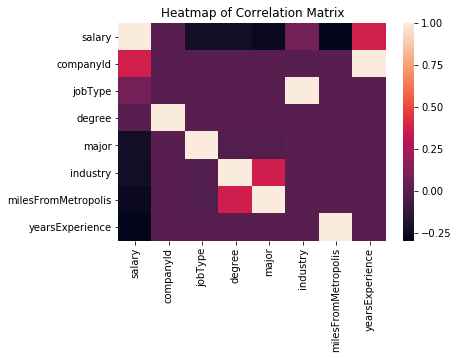

In [338]:
class Heatmap:
    def __init__(self, train_df, target, title):
        '''initializes class and concatenates train_df and target variables'''
        self.df = self._concat_df(train_df, target)
        self.col = df.columns
        self.target = target.name
        self.heatmap = self._create_corr_df(self.df, self.col, self.target, title)
        
    def _concat_df(self, train_df, target):
        '''concatenates training dataframe and target variable''' 
        return pd.concat([train_target, train_features],axis=1)
    
    def _create_corr_df(self, df, col, target, title):
        '''creates correlation matrix from train_df'''
        corr = df.corr().sort_values(target, ascending=False)
        print(corr[target])
        self._create_heatmap(corr)
        self._set_title(title)
        
    def _create_heatmap(self, corr):
        '''creates heatmap from correlation matrix'''
        return sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
        
    def _set_title(self, title):
        '''sets title of correlation matrix'''
        plt.title(title)
    
Heatmap(train_features, train_target, 'Heatmap of Correlation Matrix');

In [457]:
class Boxplot:
    def __init__(self, train_df, target, var, title):
        self.df = train_df
        self._create_subplot()
        col_avgs = self._calc_averages(df, target.name, var)
        self._create_boxplot(df, var, target, col_avgs)
        self._set_title(title)
        
    def _create_subplot(self):
        plt.subplots(figsize=(12,6.5))
        
    def _calc_averages(self, df, target, var):
        temp_df = df[[var, target]].groupby(var).mean().sort_values(target, ascending=True).reset_index()
        return temp_df[var].values

    def _create_boxplot(self, df, var, target, col_avgs):
        sns.boxplot(var, target.name, data=df, width=.3, color='#eeefff', order=col_avgs)
    
    def _set_title(self, title):
        plt.title(title)

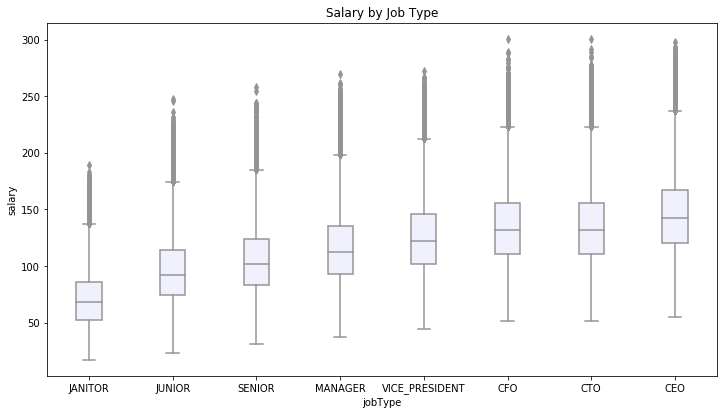

In [458]:
Boxplot(data.train_df_eda, train_target, 'jobType', 'Salary by Job Type');

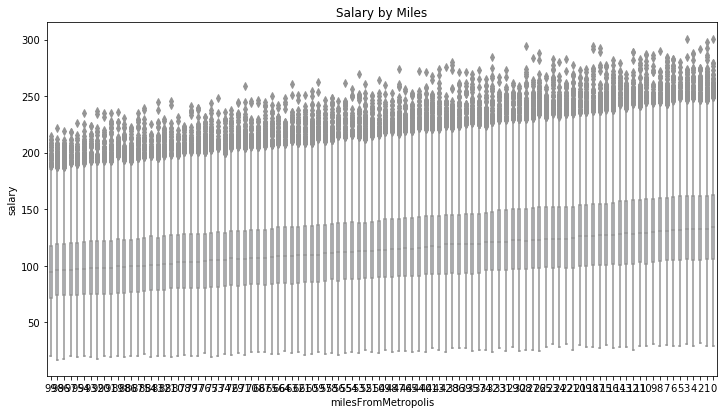

In [480]:
Boxplot(data.train_df_eda, train_target, 'milesFromMetropolis', 'Salary by Miles');

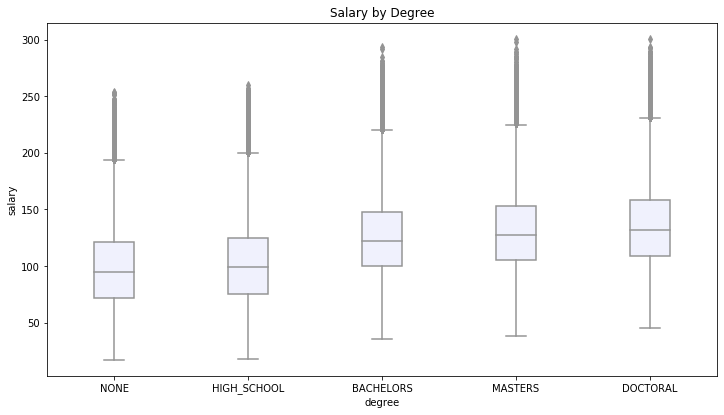

In [459]:
Boxplot(data.train_df_eda, train_target, 'degree', 'Salary by Degree');

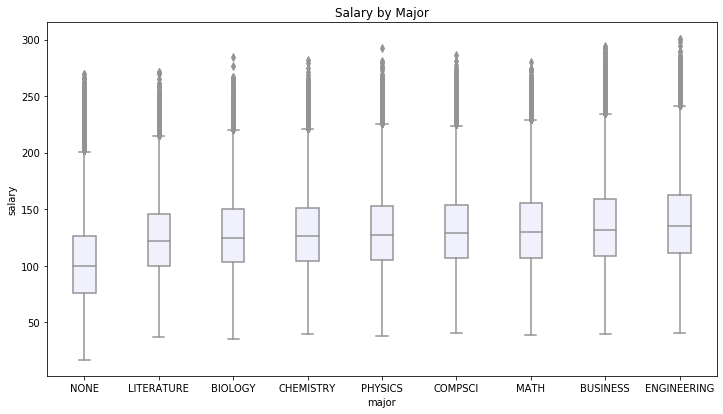

In [460]:
Boxplot(data.train_df_eda, train_target, 'major', 'Salary by Major');

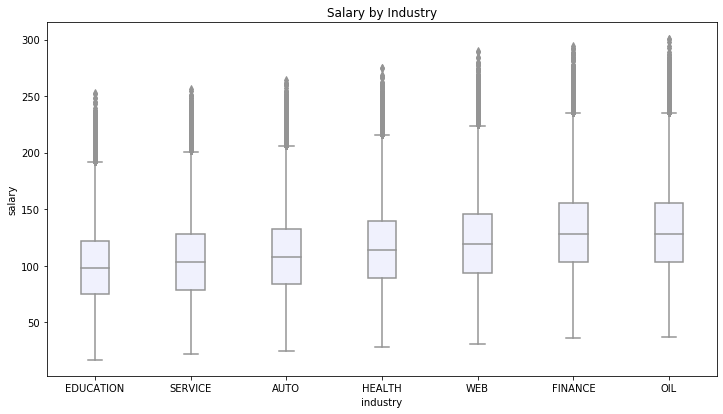

In [553]:
Boxplot(data.train_df_eda, train_target, 'industry', 'Salary by Industry');

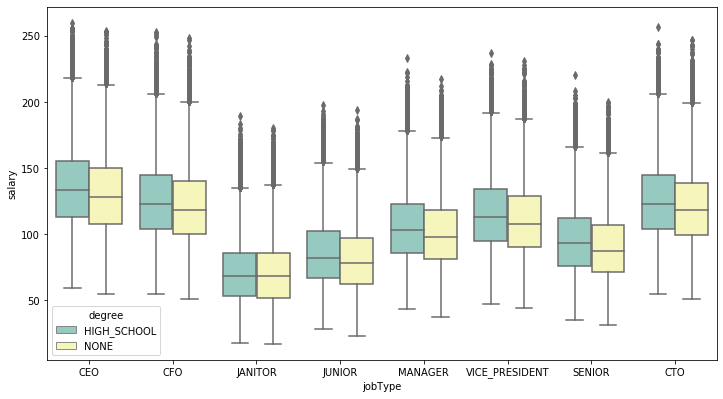

In [481]:
# clean this code
class EDA:
    def __init__(self, data):
        self.data = data
        df = data.train_df_eda
        target = data.train_df_eda.salary
        
    def boxplot(self, col1, var1, var2, col3):
        df = data.train_df_eda
        target = data.train_df_eda.salary
        df = df[(df[col1]==var1) | (df[col1]==var2)]
        f, ax = plt.subplots(figsize=(12,6.5))
        sns.boxplot(x=col3, y=target, hue=col1, data=df, palette='Set3')
        return

eda = EDA(data)
eda.boxplot('degree', 'HIGH_SCHOOL', 'NONE', 'jobType')

### ---- 5 Establish a baseline ----

In [ ]:
# we must look very carefully at the data and see opportunities to create more signal in the data that will make 
# the algorithm pick up on certain things that enhance accuracy of predictions. 

### ---- 6 Hypothesize solution ----

In [ ]:
# brainstorm 3 models that you think may improve results over the baseline model based
# read documentation and determine good models to try 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

# FEATURE ENGINEERING NOTES 
# jobType - we've already created this features
# degree - create feature, 0=high school, none, 1=others.
# degree - create another feature, 0=high school, none, 1=bachelors,masters, 2=phd

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data